(GLM-model-selection)=
# GLM: Model Selection

:::{post} Jan 8, 2022
:tags: cross validation, generalized linear model, loo, model comparison, waic 
:category: intermediate
:author: Jon Sedar, Junpeng Lao, Abhipsha Das, Oriol Abril-Pla
:::

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import xarray as xr

from ipywidgets import fixed, interactive

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

## Introduction
A fairly minimal reproducible example of Model Selection using WAIC, and LOO as currently implemented in PyMC3. 

This example creates two toy datasets under linear and quadratic models, and then tests the fit of a range of polynomial linear models upon those datasets by using Widely Applicable Information Criterion (WAIC), and leave-one-out (LOO) cross-validation using Pareto-smoothed importance sampling (PSIS). 

The example was inspired by Jake Vanderplas' [blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, although Cross-Validation and Bayes Factor comparison are not implemented. The datasets are tiny and generated within this Notebook. They contain errors in the measured value (y) only.

## Local Functions

We start writing some functions to help with the rest of the notebook. Only the some functions are key to understanding the notebook, the rest are convenience functions to make plotting more concise when needed and are hidden inside a toggle-able section; it is still available but you need to click to see it.

In [3]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20, seed=5):
    """
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e

    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical' generating
    process, rather than experimental measurement error.
    Please don't use the returned `latent_error` values in inferential
    models, it's returned in the dataframe for interest only.
    """
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({"x": rng.choice(np.arange(100), n, replace=False)})

    # create linear or quadratic model
    df["y"] = a + b * (df["x"]) + c * (df["x"]) ** 2

    # create latent noise and marked outliers
    df["latent_error"] = rng.normal(0, latent_sigma_y, n)
    df["outlier_error"] = rng.normal(0, latent_sigma_y * 10, n)
    df["outlier"] = rng.binomial(1, p, n)

    # add noise, with extreme noise for marked outliers
    df["y"] += (1 - df["outlier"]) * df["latent_error"]
    df["y"] += df["outlier"] * df["outlier_error"]

    # round
    for col in ["y", "latent_error", "outlier_error", "x"]:
        df[col] = np.round(df[col], 3)

    # add label
    df["source"] = "linear" if c == 0 else "quadratic"

    # create simple linspace for plotting true model
    plotx = np.linspace(
        df["x"].min() - np.ptp(df["x"].values) * 0.1,
        df["x"].max() + np.ptp(df["x"].values) * 0.1,
        100,
    )

    ploty = a + b * plotx + c * plotx**2
    dfp = pd.DataFrame({"x": plotx, "y": ploty})

    return df, dfp

In [4]:
def interact_dataset(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    """
    Convenience function:
    Interactively generate dataset and plot
    """

    df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(
        df,
        height=8,
        hue="outlier",
        hue_order=[True, False],
        palette=sns.color_palette("bone"),
        legend_out=False,
    )

    g.map(
        plt.errorbar,
        "x",
        "y",
        "latent_error",
        marker="o",
        ms=10,
        mec="w",
        mew=2,
        ls="",
        elinewidth=0.7,
    ).add_legend()

    plt.plot(dfp["x"], dfp["y"], "--", alpha=0.8)

    plt.subplots_adjust(top=0.92)
    g.fig.suptitle("Sketch of Data Generation ({})".format(df["source"][0]), fontsize=16)


def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
    """
    Convenience function:
    Plot the two generated datasets in facets with generative model
    """

    df = pd.concat((df_lin, df_quad), axis=0)

    g = sns.FacetGrid(col="source", hue="source", data=df, height=6, sharey=False, legend_out=False)

    g.map(plt.scatter, "x", "y", alpha=0.7, s=100, lw=2, edgecolor="w")

    g.axes[0][0].plot(dfp_lin["x"], dfp_lin["y"], "--", alpha=0.6, color="C0")
    g.axes[0][1].plot(dfp_quad["x"], dfp_quad["y"], "--", alpha=0.6, color="C0")


def plot_annotated_trace(traces):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """

    summary = az.summary(traces, stat_funcs={"mean": np.mean}, extend=False)
    ax = az.plot_trace(
        traces,
        lines=tuple([(k, {}, v["mean"]) for k, v in summary.iterrows()]),
    )

    for i, mn in enumerate(summary["mean"].values):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="C0",
        )


def plot_posterior_cr(models, idatas, rawdata, xlims, datamodelnm="linear", modelnm="k1"):
    """
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    """

    # Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = idatas[modelnm].posterior.copy().drop_vars("y_sigma")
    da = xr.concat([var for var in trc.values()], dim="order")

    ordr = int(modelnm[-1:])
    x = xr.DataArray(np.linspace(xlims[0], xlims[1], npoints), dims=["x_plot"])
    pwrs = xr.DataArray(np.arange(ordr + 1), dims=["order"])
    X = x**pwrs
    cr = xr.dot(X, da, dims="order")

    # Calculate credible regions and plot over the datapoints
    qs = cr.quantile([0.025, 0.25, 0.5, 0.75, 0.975], dim=("chain", "draw"))

    f, ax1d = plt.subplots(1, 1, figsize=(7, 7))
    f.suptitle(
        f"Posterior Predictive Fit -- Data: {datamodelnm} -- Model: {modelnm}",
        fontsize=16,
    )

    ax1d.fill_between(
        x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), alpha=0.5, color="C0", label="CR 95%"
    )
    ax1d.fill_between(
        x, qs.sel(quantile=0.25), qs.sel(quantile=0.75), alpha=0.5, color="C3", label="CR 50%"
    )
    ax1d.plot(x, qs.sel(quantile=0.5), alpha=0.6, color="C4", label="Median")
    ax1d.scatter(rawdata["x"], rawdata["y"], alpha=0.7, s=100, lw=2, edgecolor="w")

    ax1d.legend()
    ax1d.set_xlim(xlims)

## Generate toy datasets

### Interactively draft data

Throughout the rest of the Notebook, we'll use two toy datasets created by a linear and a quadratic model respectively, so that we can better evaluate the fit of the model selection.

Right now, lets use an interactive session to play around with the data generation function in this Notebook, and get a feel for the possibilities of data we could generate.


$$y_{i} = a + bx_{i} + cx_{i}^{2} + \epsilon_{i}$$

where:  
$i \in n$ datapoints

$$\epsilon \sim \mathcal{N}(0,latent\_sigma\_y)$$

:::{admonition} Note on outliers
+ We can use value `p` to set the (approximate) proportion of 'outliers' under a bernoulli distribution.
+ These outliers have a 10x larger `latent_sigma_y`
+ These outliers are labelled in the returned datasets and may be useful for other modelling, see another example Notebook: {ref}`GLM-robust-with-outlier-detection`
:::

In [5]:
interactive(
    interact_dataset,
    n=[5, 50, 5],
    p=[0, 0.5, 0.05],
    a=[-50, 50],
    b=[-10, 10],
    c=[-3, 3],
    latent_sigma_y=[0, 1000, 50],
)

interactive(children=(Dropdown(description='n', options=(5, 50, 5), value=5), Dropdown(description='p', option…

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

### Create datasets for modelling

We can use the above interactive plot to get a feel for the effect of the params. Now we'll create 2 fixed datasets to use for the remainder of the Notebook. 

1. For a start, we'll create a linear model with small noise. Keep it simple.
2. Secondly, a quadratic model with small noise

In [6]:
n = 30
df_lin, dfp_lin = generate_data(n=n, p=0, a=-30, b=5, c=0, latent_sigma_y=40, seed=RANDOM_SEED)
df_quad, dfp_quad = generate_data(n=n, p=0, a=-200, b=2, c=3, latent_sigma_y=500, seed=RANDOM_SEED)

Scatterplot against model line

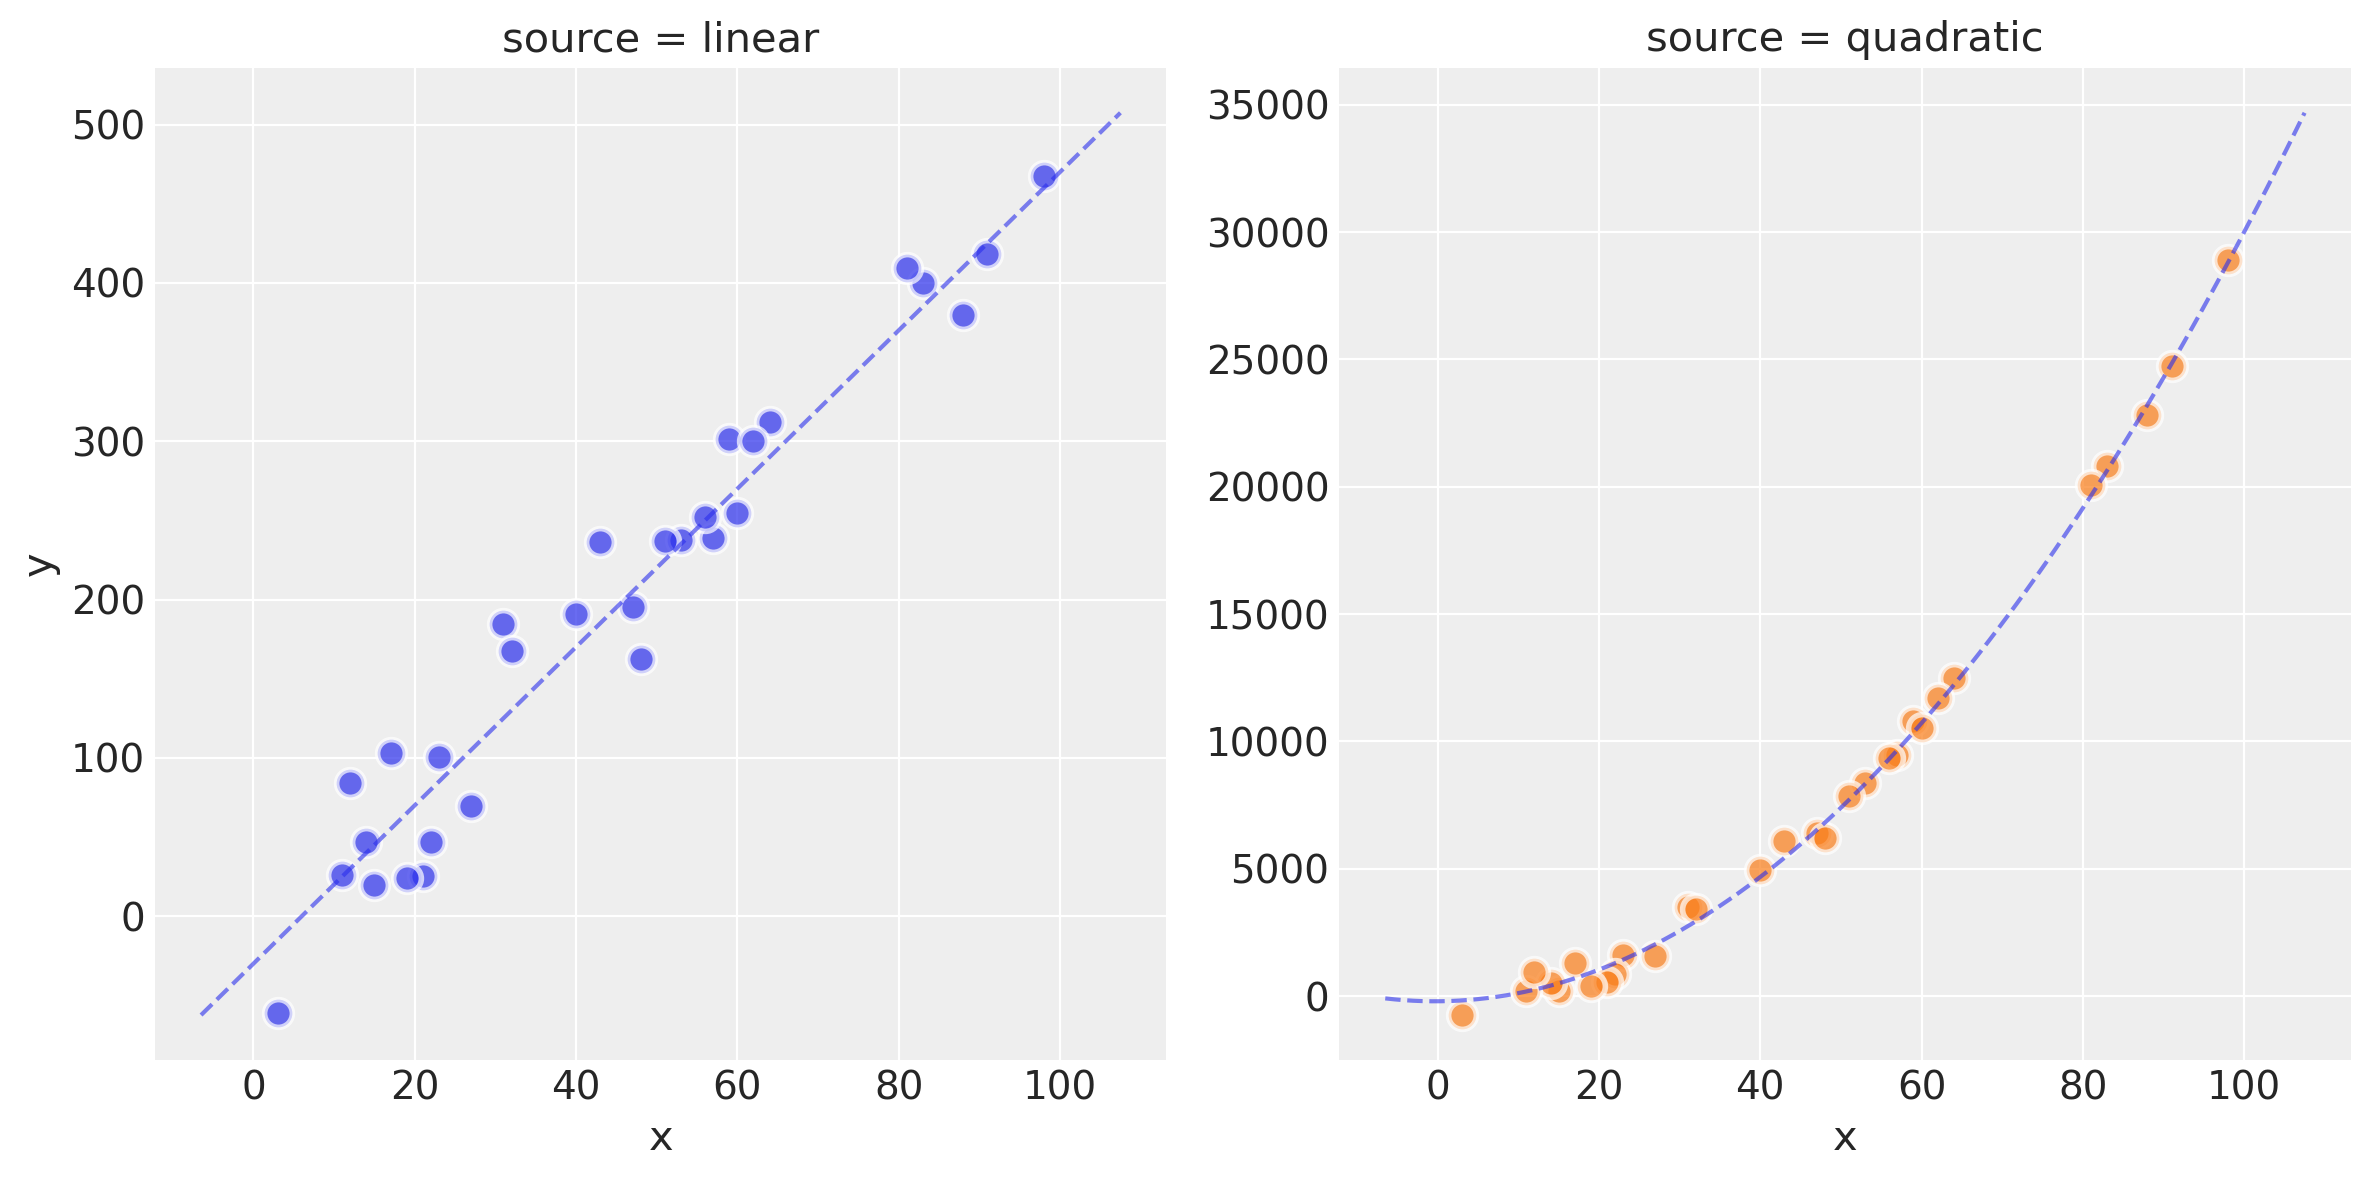

In [7]:
plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad)

**Observe:**

+ We now have two datasets `df_lin` and `df_quad` created by a linear model and quadratic model respectively.
+ You can see this raw data, the ideal model fit and the effect of the latent noise in the scatterplots above
+ In the following plots in this Notebook, the linear-generated data will be shown in Blue and the quadratic in Green.

### Standardize

In [8]:
dfs_lin = df_lin.copy()
dfs_lin["x"] = (df_lin["x"] - df_lin["x"].mean()) / df_lin["x"].std()

dfs_quad = df_quad.copy()
dfs_quad["x"] = (df_quad["x"] - df_quad["x"].mean()) / df_quad["x"].std()

Create ranges for later ylim xim

In [9]:
dfs_lin_xlims = (
    dfs_lin["x"].min() - np.ptp(dfs_lin["x"].values) / 10,
    dfs_lin["x"].max() + np.ptp(dfs_lin["x"].values) / 10,
)

dfs_lin_ylims = (
    dfs_lin["y"].min() - np.ptp(dfs_lin["y"].values) / 10,
    dfs_lin["y"].max() + np.ptp(dfs_lin["y"].values) / 10,
)

dfs_quad_ylims = (
    dfs_quad["y"].min() - np.ptp(dfs_quad["y"].values) / 10,
    dfs_quad["y"].max() + np.ptp(dfs_quad["y"].values) / 10,
)

## Demonstrate simple linear model

This *linear model* is really simple and conventional, an OLS with L2 constraints (Ridge Regression):

$$y = a + bx + \epsilon$$

### Define model using explicit PyMC3 method

In [10]:
with pm.Model() as mdl_ols:
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal("Intercept", mu=0, sigma=100)
    b1 = pm.Normal("x", mu=0, sigma=100)

    ## define Linear model
    yest = b0 + b1 * df_lin["x"]

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    y_sigma = pm.HalfCauchy("y_sigma", beta=10)
    likelihood = pm.Normal("likelihood", mu=yest, sigma=y_sigma, observed=df_lin["y"])

    idata_ols = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.886314395097965, but should be close to 0.8. Try to increase the number of tuning steps.


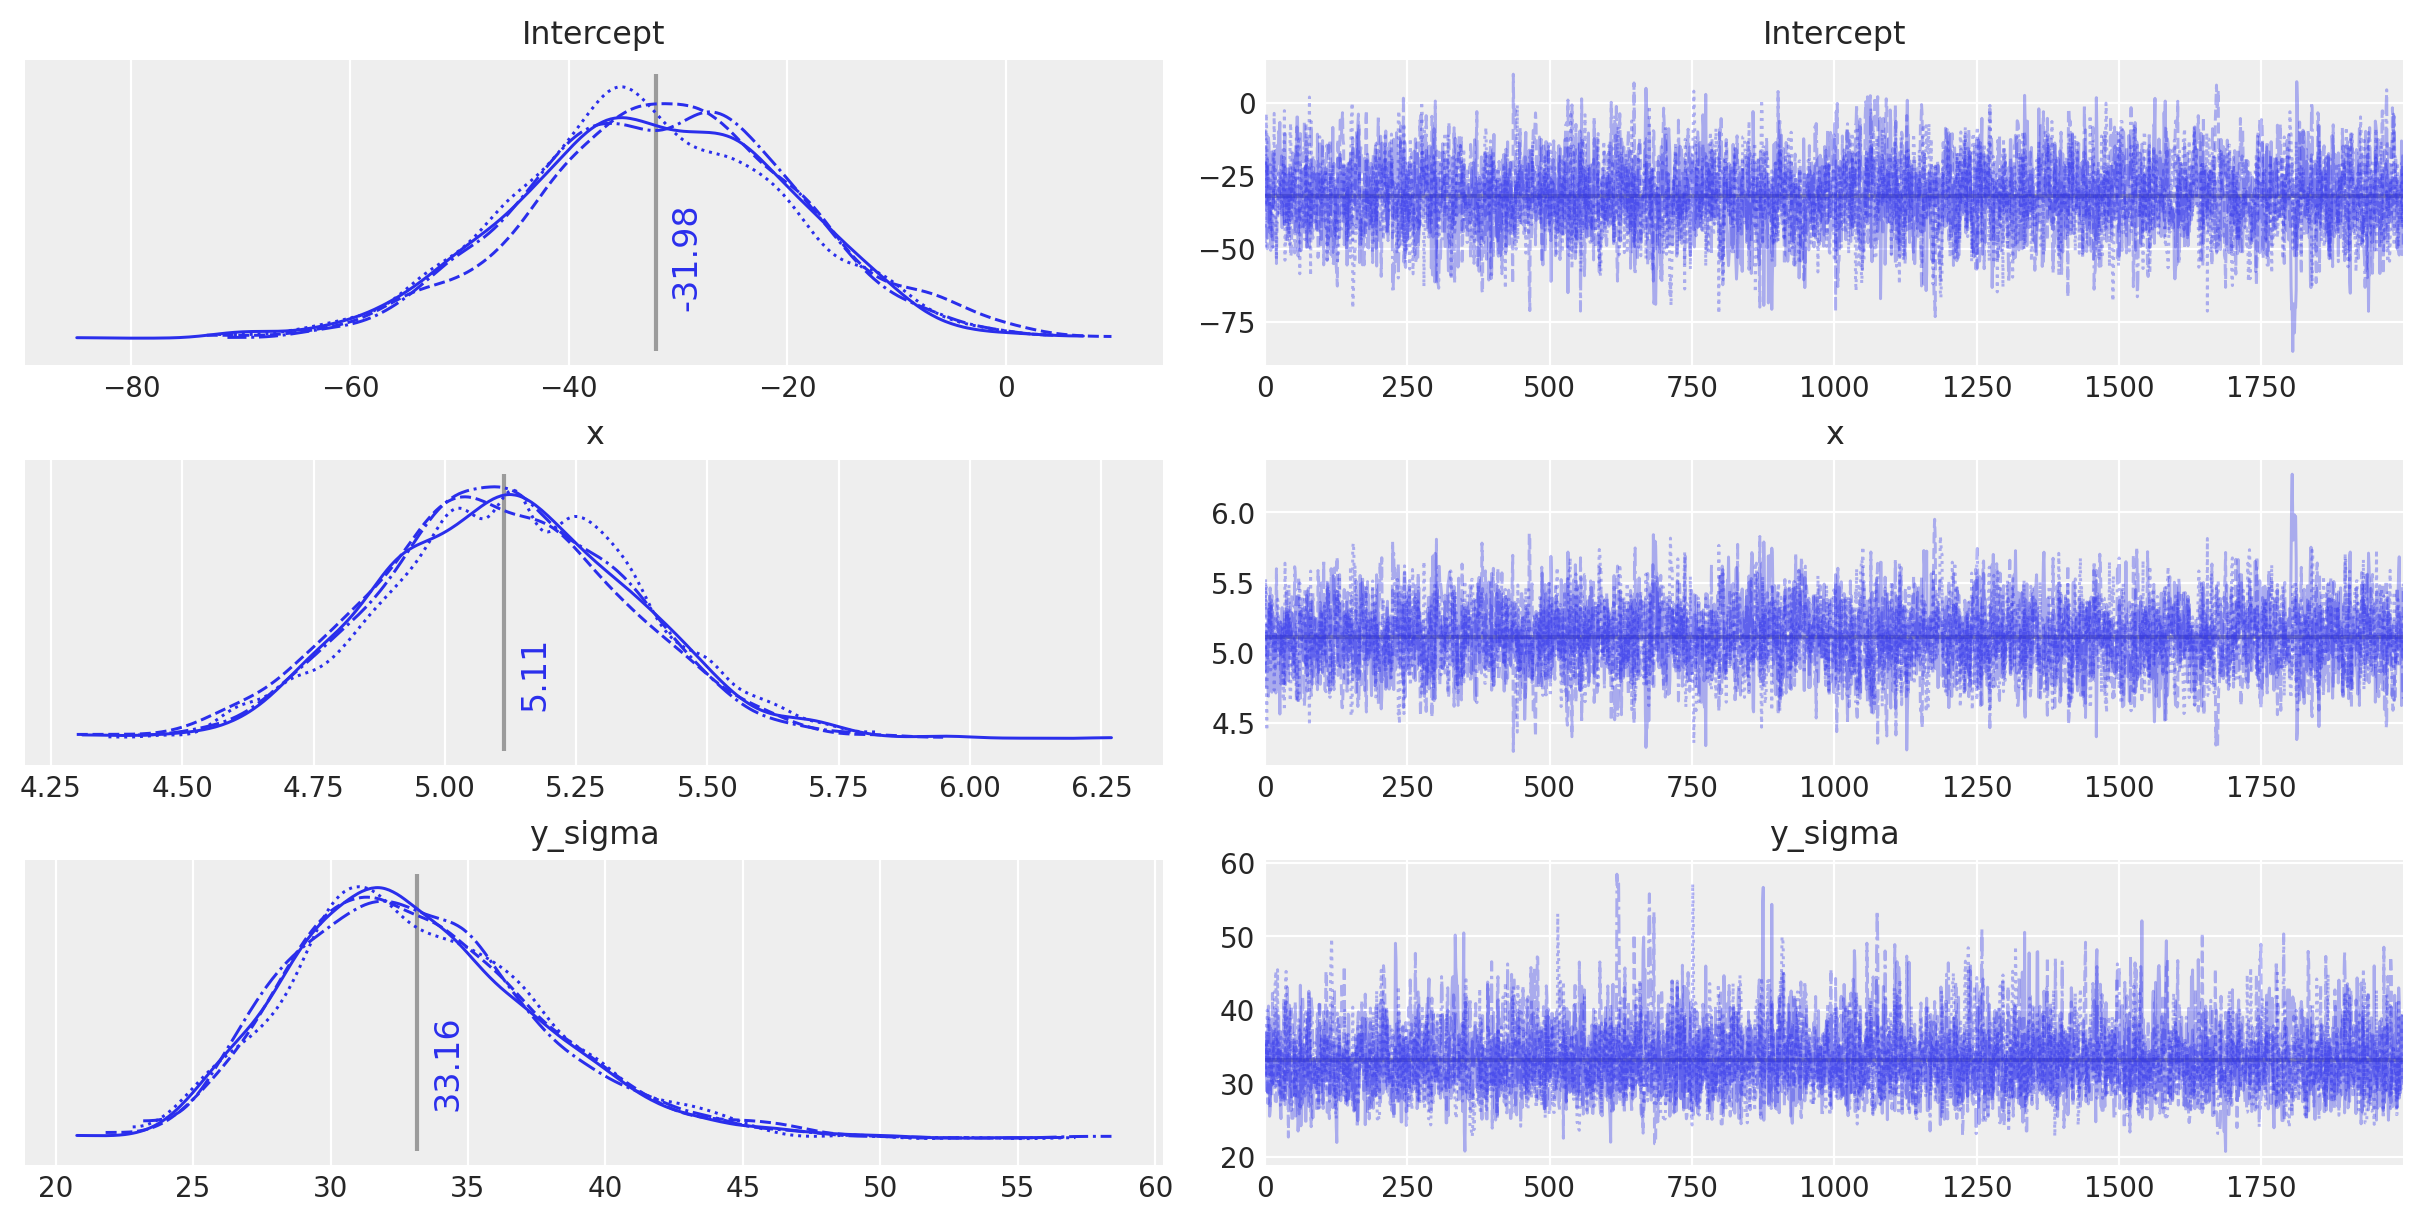

In [11]:
plt.rcParams["figure.constrained_layout.use"] = True
plot_annotated_trace(idata_ols)

**Observe:**

+ This simple OLS manages to make fairly good guesses on the model parameters - the data has been generated fairly simply after all - but it does appear to have been fooled slightly by the inherent noise.

### Define model using Bambi

Bambi can be used for defining models using a `formulae`-style formula syntax. This seems really useful, especially for defining simple regression models in fewer lines of code. 

Here's the same OLS model as above, defined using `bambi`.

In [12]:
# Define priors for intercept and regression coefficients.
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=100),
    "x": bmb.Prior("Normal", mu=0, sigma=100),
}

model = bmb.Model("y ~ 1 + x", df_lin, priors=priors, family="gaussian")

idata_ols_glm = model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


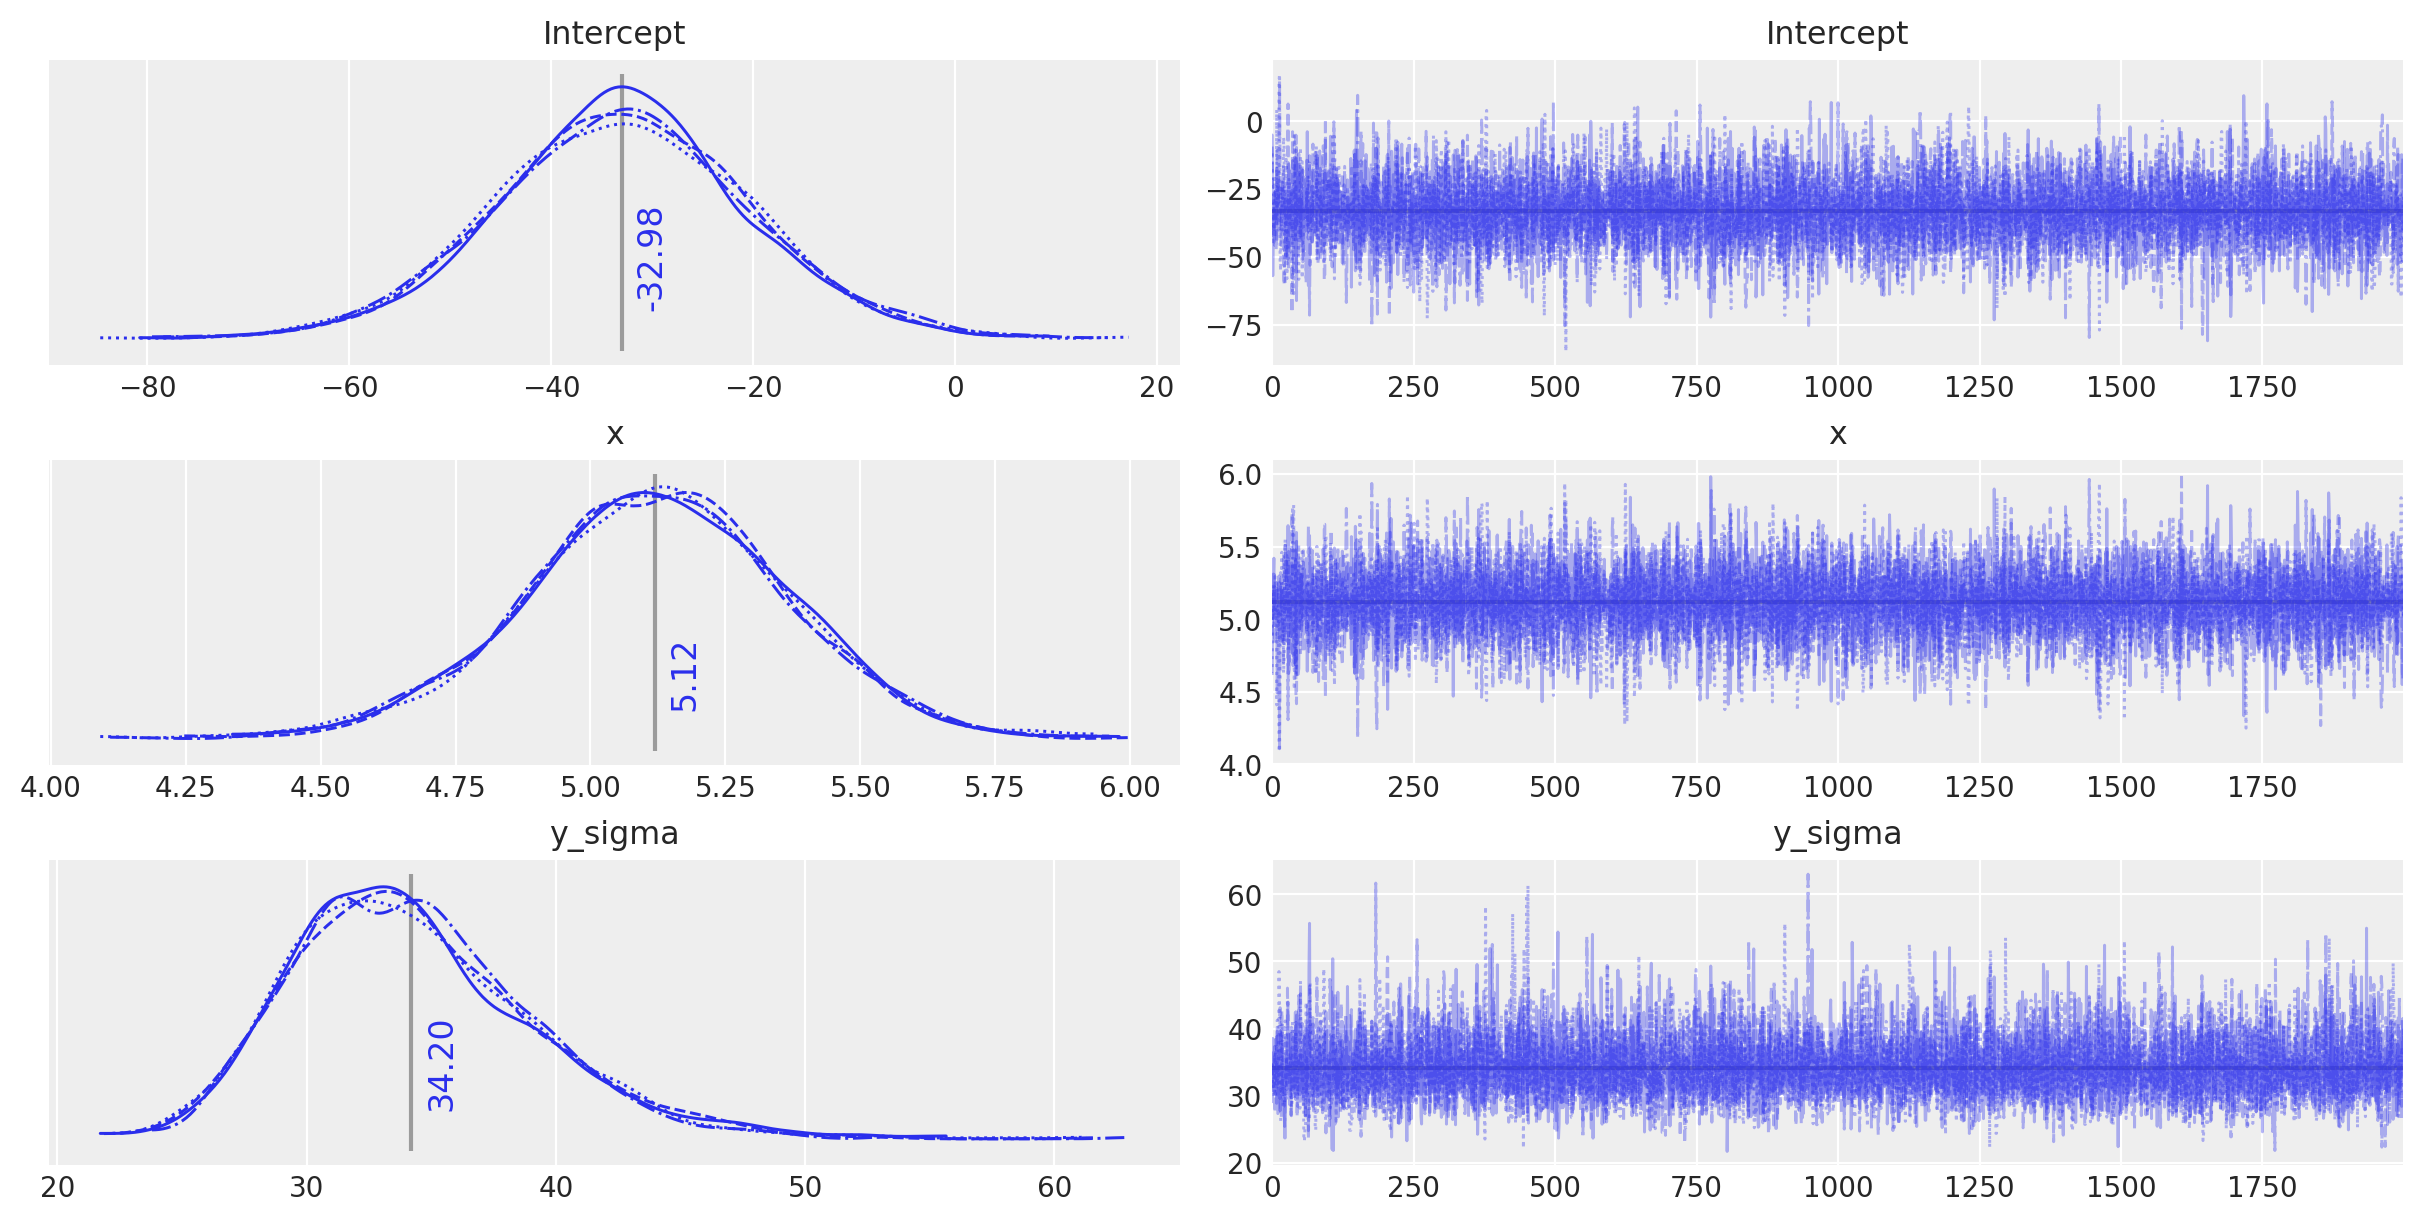

In [13]:
plot_annotated_trace(idata_ols_glm)

**Observe:**

+ This `bambi`-defined model appears to behave in a very similar way, and finds the same parameter values as the conventionally-defined model - any differences are due to the random nature of the sampling.
+ We can quite happily use the `bambi` syntax for further models below, since it allows us to create a small model factory very easily.

## Create higher-order linear models

Back to the real purpose of this Notebook, to demonstrate model selection.

First, let's create and run a set of polynomial models on each of our toy datasets. By default this is for models of order 1 to 5.

### Create and run polynomial models

We're creating 5 polynomial models and fitting each to the chosen dataset using the functions `create_poly_modelspec` and `run_models` below.

In [14]:
def create_poly_modelspec(k=1):
    """
    Convenience function:
    Create a polynomial modelspec string for bambi
    """
    return ("y ~ 1 + x " + " ".join([f"+ np.power(x,{j})" for j in range(2, k + 1)])).strip()


def run_models(df, upper_order=5):
    """
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    """

    models, results = dict(), dict()

    for k in range(1, upper_order + 1):

        nm = f"k{k}"
        fml = create_poly_modelspec(k)

        print(f"\nRunning: {nm}")

        models[nm] = bmb.Model(
            fml, df, priors={"intercept": bmb.Prior("Normal", mu=0, sigma=100)}, family="gaussian"
        )
        results[nm] = models[nm].fit(draws=2000, tune=1000, init="advi+adapt_diag")

    return models, results

In [15]:
models_lin, idatas_lin = run_models(dfs_lin, 5)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 206
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 210.55
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 213.58
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.



Running: k4


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 216.86
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 4), np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8819029722250732, but should be close to 0.8. Try to increase the number of tuning steps.



Running: k5


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 219.06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 5), np.power(x, 4), np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [16]:
models_quad, idatas_quad = run_models(dfs_quad, 5)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 336.87
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 346.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 354.21
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6356752238454105, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.



Running: k4


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 361.87
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 4), np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.



Running: k5


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 368.94
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, np.power(x, 5), np.power(x, 4), np.power(x, 3), np.power(x, 2), x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9001195215217999, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


## View posterior predictive fit

Just for the linear, generated data, lets take an interactive look at the posterior predictive fit for the models k1 through k5.

As indicated by the likelhood plots above, the higher-order polynomial models exhibit some quite wild swings in the function in order to (over)fit the data

In [17]:
interactive(
    plot_posterior_cr,
    models=fixed(models_lin),
    idatas=fixed(idatas_lin),
    rawdata=fixed(dfs_lin),
    xlims=fixed(dfs_lin_xlims),
    datamodelnm=fixed("linear"),
    modelnm=["k1", "k2", "k3", "k4", "k5"],
)

interactive(children=(Dropdown(description='modelnm', options=('k1', 'k2', 'k3', 'k4', 'k5'), value='k1'), Out…

## Compare models using WAIC

The Widely Applicable Information Criterion (WAIC) can be used to calculate the goodness-of-fit of a model using numerical techniques. See {cite:t}`watanabe2010asymptotic` for details.

**Observe:**

We get three different measurements: 
- waic: widely applicable information criterion (or "Watanabe–Akaike information criterion")
- waic_se: standard error of waic
- p_waic: effective number parameters
    
In this case we are interested in the WAIC score. We also plot error bars for the standard error of the estimated scores. This gives us a more accurate view of how much they might differ.

In [18]:
dfwaic_lin = az.compare(idatas_lin, ic="WAIC")
dfwaic_quad = az.compare(idatas_quad, ic="WAIC")

/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/stats.py:1491: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/stats.py:1491: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/stats.py:1491: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packag

In [19]:
dfwaic_lin

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
k1,0,-149.117557,2.345789,0.000000,1.000000e+00,2.712912,0.000000,False,log
k2,1,-149.602476,3.020848,0.484919,6.401130e-16,2.837751,0.803918,True,log
k3,2,-150.602409,3.721614,1.484851,2.407190e-15,2.777387,0.853239,True,log
k4,3,-151.411297,4.254917,2.293740,2.194139e-15,2.684069,0.878195,True,log
k5,4,-152.481775,5.040347,3.364217,0.000000e+00,2.662009,0.806270,True,log


In [20]:
dfwaic_quad

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
k2,0,-225.391799,3.002856,0.000000,1.000000e+00,2.818772,0.000000,True,log
k3,1,-226.368588,3.709239,0.976789,0.000000e+00,2.762794,0.327095,True,log
k4,2,-227.392991,4.444871,2.001191,0.000000e+00,2.720125,0.636527,True,log
k5,3,-228.251205,4.943613,2.859405,0.000000e+00,2.597084,0.776222,True,log
k1,4,-274.311114,3.433617,48.919315,2.383094e-11,3.916081,4.858806,True,log


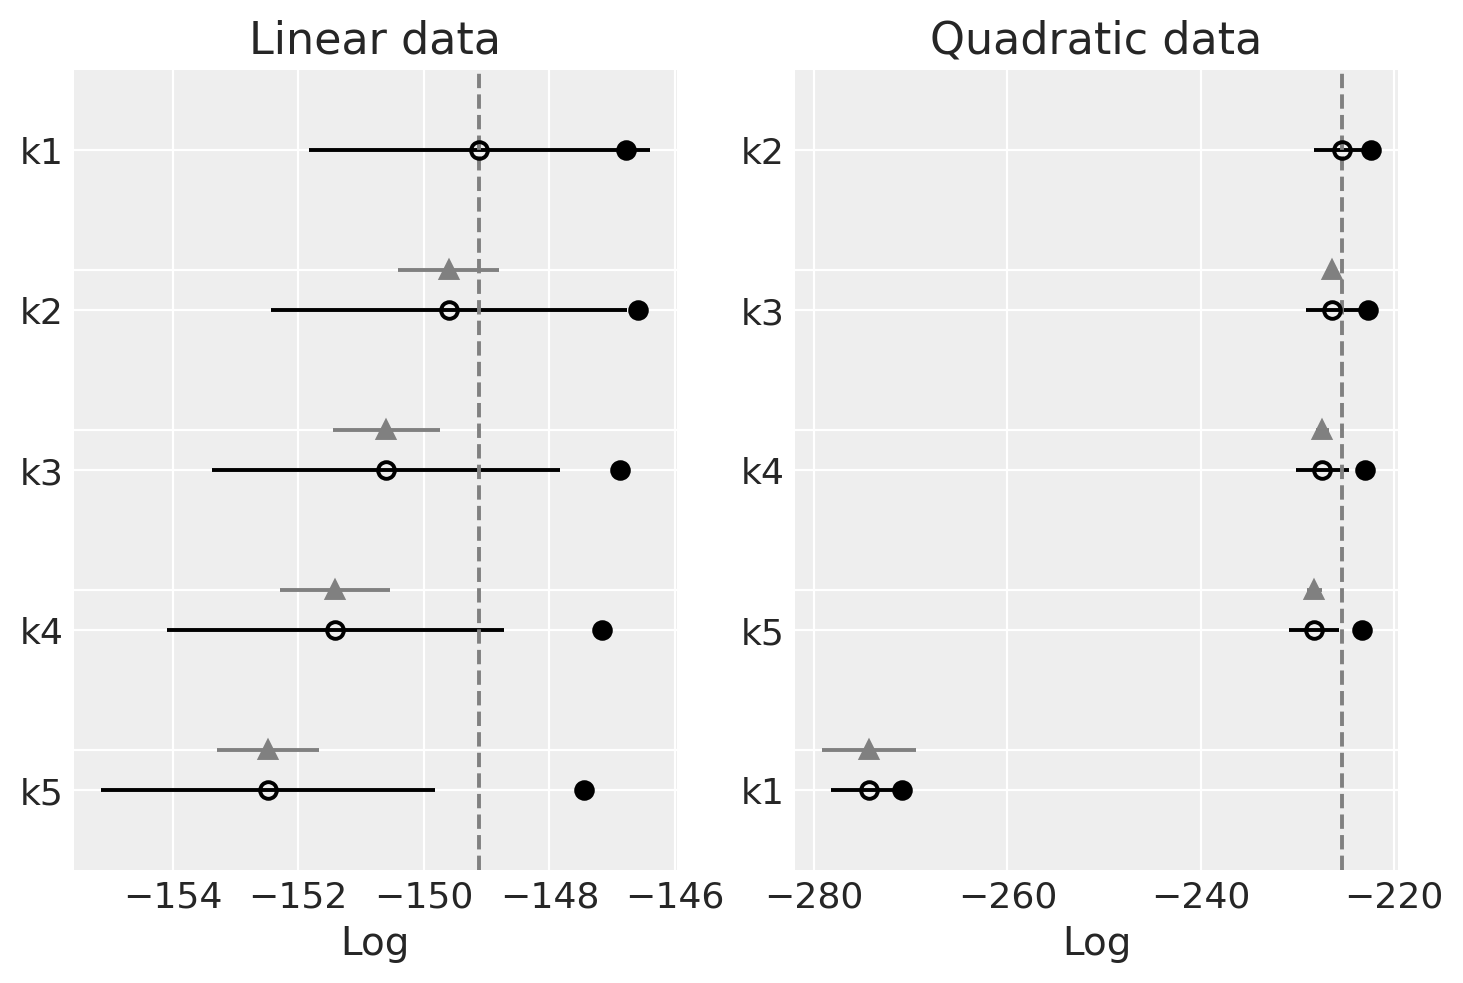

In [21]:
_, axs = plt.subplots(1, 2)

ax = axs[0]
az.plot_compare(dfwaic_lin, ax=ax)
ax.set_title("Linear data")

ax = axs[1]
az.plot_compare(dfwaic_quad, ax=ax)
ax.set_title("Quadratic data");

**Observe**

+ We should prefer the model(s) with higher WAIC


+ Linear-generated data (lhs):
    + The WAIC seems quite flat across models
    + The WAIC seems best (highest) for simpler models.


+ Quadratic-generated data (rhs):
    + The WAIC is also quite flat across the models
    + The worst WAIC is for **k1**, it is not flexible enough to properly fit the data.
    + WAIC is quite flat for the rest, but the highest is for **k2** as should be and it decreases as the order increases. The higher the order the higher the complexity of the model, but the goodness of fit is basically the same. As models with higher complexity are penalized we can see how we land at the sweet spot of choosing the simplest model that can fit the data.

## Compare leave-one-out Cross-Validation [LOO]

Leave-One-Out Cross-Validation or K-fold Cross-Validation is another quite universal approach for model selection. However, to implement K-fold cross-validation we need to partition the data repeatedly and fit the model on every partition. It can be very time consumming (computation time increase roughly as a factor of K). Here we are applying the numerical approach using the posterior trace as suggested in {cite:t}`vehtari2017practical`

In [22]:
dfloo_lin = az.compare(idatas_lin, ic="LOO")
dfloo_quad = az.compare(idatas_quad, ic="LOO")

/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/stats.py:703: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/stats.py:703: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oriol/miniconda3/envs/pymc-v3/lib/

In [23]:
dfloo_lin

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
k1,0,-149.143334,2.371565,0.000000,1.000000e+00,2.719166,0.000000,False,log
k2,1,-149.692788,3.111160,0.549454,1.770806e-14,2.854122,0.808749,False,log
k3,2,-150.815225,3.934430,1.671890,1.261129e-14,2.809695,0.852309,False,log
k4,3,-151.875401,4.719021,2.732067,8.919651e-15,2.750613,0.967395,True,log
k5,4,-153.319706,5.878278,4.176372,0.000000e+00,2.805217,1.058934,True,log


In [24]:
dfloo_quad

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
k2,0,-225.464584,3.075641,0.000000,1.000000e+00,2.833440,0.000000,False,log
k3,1,-226.535084,3.875735,1.070500,1.290357e-12,2.784418,0.362643,False,log
k4,2,-227.987866,5.039746,2.523282,1.286804e-12,2.823319,0.882205,True,log
k5,3,-229.054152,5.746561,3.589568,1.116274e-12,2.740229,1.036157,True,log
k1,4,-274.409459,3.531961,48.944875,0.000000e+00,3.979691,4.908271,False,log


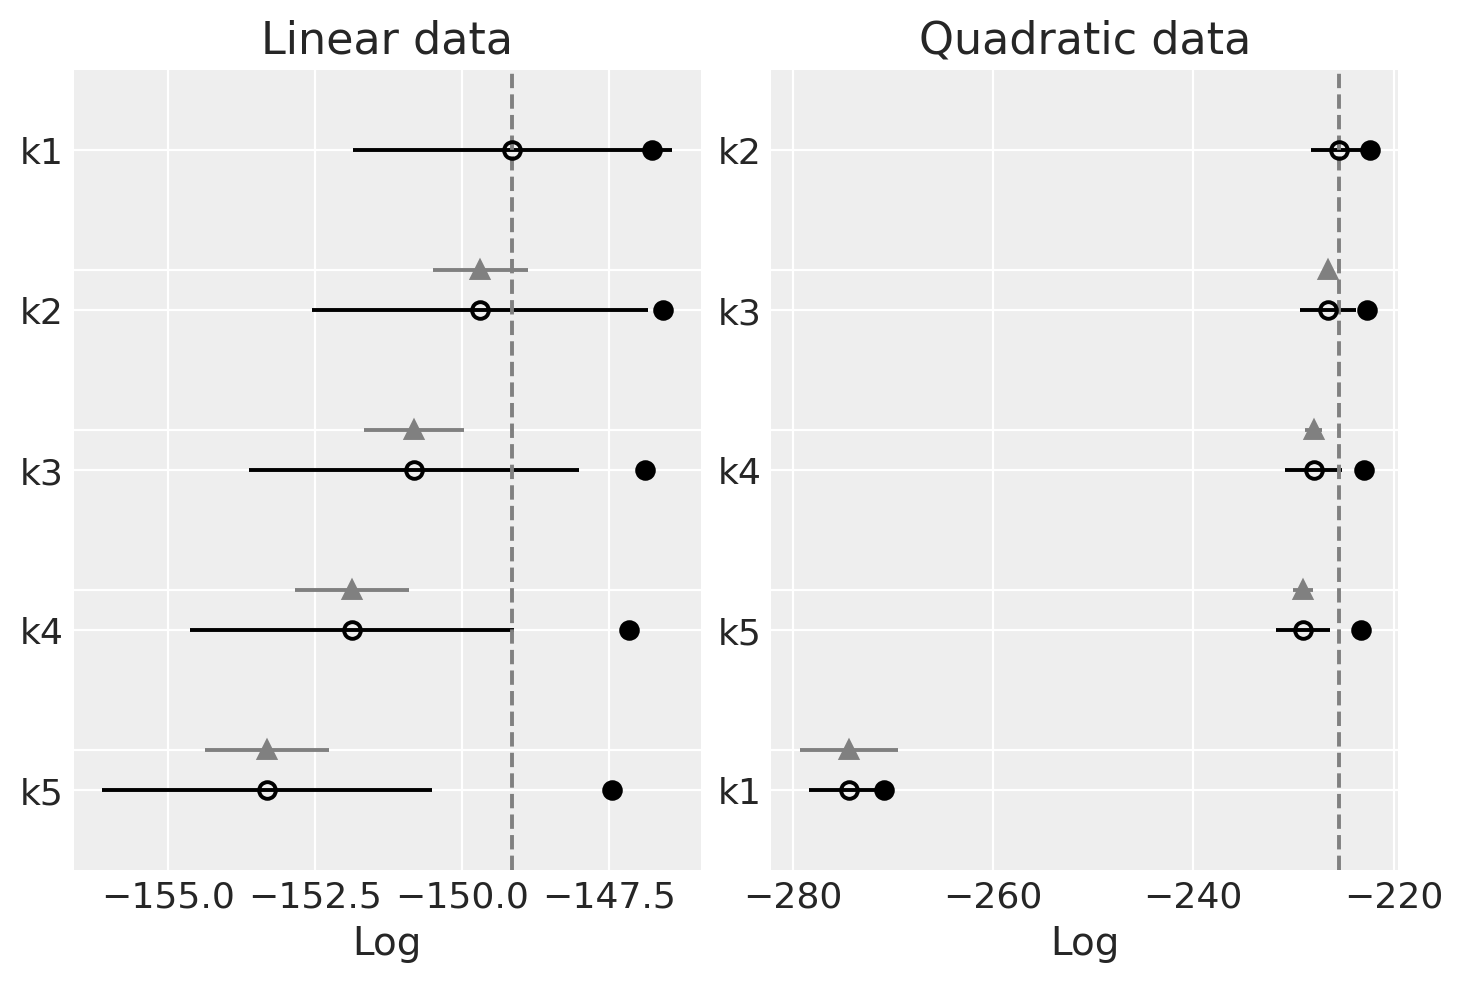

In [25]:
_, axs = plt.subplots(1, 2)

ax = axs[0]
az.plot_compare(dfloo_lin, ax=ax)
ax.set_title("Linear data")

ax = axs[1]
az.plot_compare(dfloo_quad, ax=ax)
ax.set_title("Quadratic data");

**Observe**

+ We should prefer the model(s) with higher LOO. You can see that LOO is nearly identical with WAIC. That's because WAIC is asymptotically equal to LOO. However, PSIS-LOO is supposedly more robust than WAIC in the finite case (under weak priors or influential observation). 


+ Linear-generated data (lhs):
    + The LOO is also quite flat across models
    + The LOO is also seems best (highest) for simpler models.


+ Quadratic-generated data (rhs):
    + The same pattern as the WAIC

## Final remarks and tips

It is important to keep in mind that, with more data points, the real underlying model (one that we used to generate the data) should outperform other models. 

There is some agreement that PSIS-LOO offers the best indication of a model's quality. To quote from [avehtari's comment](https://github.com/pymc-devs/pymc3/issues/938#issuecomment-313425552): "I also recommend using PSIS-LOO instead of WAIC, because it's more reliable and has better diagnostics as discussed in {cite:t}`vehtari2017practical`, but if you insist to have one information criterion then leave WAIC". 

Alternatively, Watanabe [says](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/index.html) "WAIC is a better approximator of the generalization error than the pareto smoothing importance sampling cross validation. The Pareto smoothing cross validation may be the better approximator of the cross validation than WAIC, however, it is not of the generalization error".

## References

:::{bibliography}
:filter: docname in docnames

ando2007bayesian
spiegelhalter2002bayesian
:::

:::{seealso}
+ Thomas Wiecki's [detailed response](https://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3/166383#166383) to a question on Cross Validated
+ [Cross-validation FAQs](https://avehtari.github.io/modelselection/CV-FAQ.html) by Aki Vehtari
:::

## Authors
* Authored by [Jon Sedar](https://github.com/jonsedar) on January, 2016 ([pymc#930](https://github.com/pymc-devs/pymc/pull/930))
* Updated by [Junpeng Lao](https://github.com/junpenglao) on July, 2017 ([pymc#2398](https://github.com/pymc-devs/pymc/pull/2398))
* Re-executed by Ravin Kumar on May, 2019 ([pymc#3397](https://github.com/pymc-devs/pymc/pull/3397))
* Re-executed by Alex Andorra and Michael Osthege on June, 2020 ([pymc#3955](https://github.com/pymc-devs/pymc/pull/3955))
* Updated by Raul Maldonado on March, 2021 ([pymc-examples#24](https://github.com/pymc-devs/pymc-examples/pull/24))
* Updated by Abhipsha Das and Oriol Abril on June, 2021 ([pymc-examples#173](https://github.com/pymc-devs/pymc-examples/pull/173))

## Watermark

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Sat Jan 08 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

theano: 1.1.2
xarray: 0.20.1

arviz     : 0.11.4
pandas    : 1.3.4
numpy     : 1.21.4
matplotlib: 3.4.3
seaborn   : 0.11.2
bambi     : 0.6.3
xarray    : 0.20.1
pymc3     : 3.11.4

Watermark: 2.2.0



:::{include} ../page_footer.md
:::